In [1]:
import cv2
import skimage.io
import numpy as np
import tkinter as tk
from tkinter import *
from helpers import *
from functions import *
from matplotlib import pyplot as plt
from tkinter import filedialog as fd
from tkinter import messagebox as mb


def loadConfig(fname):
    config = loadPickle(fname)
    for key in config.keys():
        globals()[str(key)] = config[key]
    globals()['configFile'] = fname
    
try:
    loadConfig('config.pkl')
except:
    print("Failed to load the config file!")
    quit()
    
img = skimage.io.imread('dock.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [2]:
class Retina:
    def __init__(self, fname):
        self.backProjectedVector = None
        self.normalizationVector = None
        
        self.input_resolution = None
        self.sampledVector = None
        self.coeff_layers = None
        self.index_layers = None
        
        self.retina_size = None
        self.crop_coords = None
        self.backProject = None
        self.scalingFactor = None
        self.fixation = None
        self.sample = None
        
        self.layersFile = fname
 
        #################################
        #################################
        #################################
#         self.optimumNumThreads = None

        try:
            self.loadLayers()
        except:
            print("Could not find previously saved layers, Please make sure to initlaize them!")

    def loadLayers(self):
        self.coeff_layers, self.index_layers, self.scalingFactor = loadPickle(self.layersFile)
        self.sampledVector = np.zeros(numFields).astype(numpy_types[types['RESULTS']])
        
    def setInputResolution(self, w, h):
        self.input_resolution = np.array([h,w], dtype='int32')
        
    def setFixation(self, x, y):
        layers = loadPickle(self.layersFile)
        if self.coeff_layers is None:
            self.coeff_layers = layers[0]
            self.index_layers = layers[1]
        if self.retina_size is None:
            self.retina_size = np.array(layers[0][0].shape, dtype='int32')
        self.fixation = np.array([x,y], dtype='int32')
        layer_shape = np.array(layers[0][0].shape, dtype='int32')
        img_x1, img_y1, img_x2, img_y2, ret_x1, ret_y1, ret_x2, ret_y2 = get_bounds(self.input_resolution, layer_shape, self.fixation)
        self.crop_coords = (img_x1, img_y1, img_x2, img_y2)
        for i in range(len(layers[0])):
            self.coeff_layers[i] = layers[0][i][ret_y1:ret_y2, ret_x1:ret_x2].ravel()
            self.index_layers[i] = layers[1][i][ret_y1:ret_y2, ret_x1:ret_x2].ravel()
        self.retina_size = np.array([img_y2 - img_y1,img_x2 - img_x1], dtype='int32')
        self.createNormalizationImage()
########################################
############## GRAY SCALE ##############
########################################
            
    def sample_gray(self, img):
        #################################
        #################################
        #################################
        zeros_int32(self.sampledVector)
        x1, y1, x2, y2 = self.crop_coords
        img = img[y1:y2, x1:x2].ravel()
        for i in range(len(self.coeff_layers)):
            sample(img, self.coeff_layers[i], self.index_layers[i], self.sampledVector)
            
    def createNormalizationImage_gray(self): # CAN CREATE VECTORS?
        #################################
        #################################
        #################################
        self.backProjectedVector = np.zeros(self.retina_size).astype(numpy_types[types['BAKC_PROJECTED']]).ravel()
        ones = np.ones(self.input_resolution).astype(numpy_types[types['INPUT']])
        self.sample(ones)
        for i in range(len(self.coeff_layers)):
            backProject(self.sampledVector, self.coeff_layers[i], self.index_layers[i], self.backProjectedVector)
        self.normalizationVector = np.copy(self.backProjectedVector)
        self.normalizationVector[np.where(self.normalizationVector==0)]=1
            
    def backProject_gray(self):
        #################################
        #################################
        #################################
        zeros_int32(self.backProjectedVector)
        for i in range(len(self.coeff_layers)):
            backProject(self.sampledVector, self.coeff_layers[i], self.index_layers[i], self.backProjectedVector)
        normalize(self.backProjectedVector, self.normalizationVector)
        
    def sample_rgb(self, img):
        zeros_int32(self.sampledVector[0])
        zeros_int32(self.sampledVector[1])
        zeros_int32(self.sampledVector[2])
        x1, y1, x2, y2 = self.crop_coords
        img = img[y1:y2, x1:x2, :]
        R = img[:,:,0].ravel()
        G = img[:,:,1].ravel()
        B = img[:,:,2].ravel()
        for i in range(len(self.coeff_layers)):
            sampleRGB(R, G, B, self.coeff_layers[i], self.index_layers[i], self.sampledVector[0], self.sampledVector[1], self.sampledVector[2])
    
    def createNormalizationImage_rgb(self):
        self.backProjectedVector = np.zeros((3, self.retina_size[0]*self.retina_size[1])).astype(numpy_types[types['BAKC_PROJECTED']])
        ones = np.ones((self.input_resolution[0], self.input_resolution[1], 3)).astype(numpy_types[types['INPUT']])
        self.sample(ones)
        for i in range(len(self.coeff_layers)):
            backProject(self.sampledVector[0], self.coeff_layers[i], self.index_layers[i], self.backProjectedVector[0])
        self.normalizationVector = np.copy(self.backProjectedVector[0])
        self.normalizationVector[np.where(self.normalizationVector==0)]=1
    
    def backProject_rgb(self):
        zeros_int32(self.backProjectedVector[0])
        zeros_int32(self.backProjectedVector[1])
        zeros_int32(self.backProjectedVector[2])
        for i in range(len(self.coeff_layers)):
            backProjectRGB(self.sampledVector[0], self.sampledVector[1], self.sampledVector[2], self.coeff_layers[i], self.index_layers[i], self.backProjectedVector[0], self.backProjectedVector[1], self.backProjectedVector[2])
        normalize(self.backProjectedVector[0], self.normalizationVector)
        normalize(self.backProjectedVector[1], self.normalizationVector)
        normalize(self.backProjectedVector[2], self.normalizationVector)
        
#########################################
################## RGB ##################
#########################################

    def calibrate(self, img):
        ################################
        ################################
        ######## CREATE VECTORS ########
        ################################
        ################################
        rgb = (len(img.shape)==3) and (img.shape[-1]==3)
        if rgb:
            self.sampledVector = np.zeros((3,numFields)).astype(numpy_types[types['RESULTS']])
            self.sample = self.sample_rgb
            self.backProject = self.backProject_rgb
            self.createNormalizationImage = self.createNormalizationImage_rgb
        else:
            self.sampledVector = np.zeros(numFields).astype(numpy_types[types['RESULTS']])
            self.sample = self.sample_gray
            self.backProject = self.backProject_gray
            self.createNormalizationImage = self.createNormalizationImage_gray

        self.setInputResolution(img.shape[1],img.shape[0])
        self.setFixation(img.shape[1]/2,img.shape[0]/2)

In [3]:
def show_backProjected(retina, figsize=(16,9)):
    h, w = retina.retina_size
    plt.figure(figsize=figsize)
    plt.imshow(retina.backProjectedVector[:h*w].reshape((h,w)), cmap='gray')
    plt.show()
    
def show_backProjected_RGB(retina, figsize=(16,9)):
    h, w = retina.retina_size
    plt.figure(figsize=figsize)
    R = retina.backProjectedVector[0, :h*w]
    G = retina.backProjectedVector[1, :h*w]
    B = retina.backProjectedVector[2, :h*w]
    RGB = np.dstack([R,G,B]).reshape((h,w,3)).astype('uint8')
    plt.imshow(RGB)
    plt.show()
    
def get_backProjected(retina, figsize=(16,9)):
    h, w = retina.retina_size
    return retina.backProjectedVector[:h*w].reshape((h,w))
    
def get_backProjected_RGB(retina, figsize=(16,9)):
    h, w = retina.retina_size
    R = retina.backProjectedVector[0, :h*w]
    G = retina.backProjectedVector[1, :h*w]
    B = retina.backProjectedVector[2, :h*w]
    return np.dstack([R,G,B]).reshape((h,w,3)).astype('uint8')

def get_backProjected_BGR(retina, figsize=(16,9)):
    h, w = retina.retina_size
    R = retina.backProjectedVector[0, :h*w]
    G = retina.backProjectedVector[1, :h*w]
    B = retina.backProjectedVector[2, :h*w]
    return np.dstack([B,G,R]).reshape((h,w,3)).astype('uint8')

In [4]:
fixation_demo = False

if fixation_demo:
    
    R = Retina('retina_layers.pkl')
    R.calibrate(img)
    
    n = 100
    r = 0.55 * R.input_resolution[0]
    xs = np.array([int(np.cos(2*np.pi/n*x)*r) for x in range(0,n+1)]) + R.input_resolution[1]//2
    ys = np.array([int(np.sin(2*np.pi/n*x)*r) for x in range(0,n+1)]) + R.input_resolution[0]//2

    print("Path of retina over the image")
    plt.figure(figsize=(16,9))
    plt.plot(xs,ys, '.')
    plt.plot([0,img_gray.shape[1],img_gray.shape[1],0,0],[0,0,img_gray.shape[0],img_gray.shape[0],0],'r', ls='--')
    plt.gca().invert_yaxis()
    plt.show()

    i = 0
    while True:
        R.setFixation(xs[i],ys[i])
        R.sample(img)
        R.backProject()
        h, w = R.retina_size
        cv2.imshow('Back Projected',get_backProjected_BGR(R))
        key = cv2.waitKey(1)
        if key == 27: #esc
                break
        i+=1
        if i==len(xs):
            i=0
    cv2.destroyAllWindows()

In [5]:
live_demo = False

if live_demo:
    cap = cv2.VideoCapture(0)

    #Define capture resolution
    #If the actual set values are not supported by the camera,
    #highest supported values below the entered numbers is selected
    cap.set(3, 1920)
    cap.set(4, 1080)
    ret, calibration_image = cap.read()
    calibration_image = cv2.cvtColor(calibration_image, cv2.COLOR_BGR2GRAY)
    print("Actual resolution was set to %ix%i" %calibration_image.shape[::-1])

    R = Retina('retina_layers.pkl')
    R.calibrate(calibration_image)
    h, w = R.retina_size

    try:
        while(cap.isOpened()):
            ret, frame = cap.read()
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            R.sample(gray)
            R.backProject()
            cv2.imshow('Capture',gray)
            cv2.imshow('Back Projected',R.backProjectedVector[:h*w].reshape((h,w)).astype('uint8'))
            key = cv2.waitKey(1)
            if key == 27: #esc
                    break
    finally:
        cap.release()
        cv2.destroyAllWindows()

# PLEASE IGNORE THE CELLS BELOW
### (FOR DEVELOPMENT PURPOSES ONLY!)

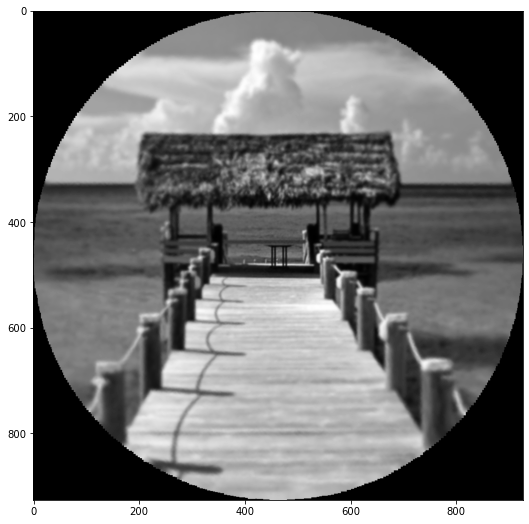

##################################################
BEFORE SAMPLING:
Mean ± STD: 100.000 ± 0.000
Range: 100.000 <-> 100.000
##################################################
AFTER SAMPLING:
Mean ± STD: 100.000 ± 0.000
Range: 100.000 <-> 100.000
##################################################


In [6]:
R = Retina('retina_layers.pkl')
R.calibrate(img_gray)
R.sample(img_gray)
R.backProject()
show_backProjected(R)
quantization_test = (np.ones(R.input_resolution)*100).astype(numpy_types[types['INPUT']])
print('#'*50)
print("BEFORE SAMPLING:")
mean = np.mean(quantization_test)
std = np.std(quantization_test)
print("Mean ± STD: %.3f ± %.3f" %(mean, std))
print("Range: %.3f <-> %.3f" %(np.min(quantization_test), np.max(quantization_test)))
print('#'*50)
R.sample(quantization_test)
R.backProject()
result = R.backProjectedVector[np.where(R.backProjectedVector > 0)]
mean = np.mean(result)
std = np.std(result)
print("AFTER SAMPLING:")
print("Mean ± STD: %.3f ± %.3f" %(mean, std))
print("Range: %.3f <-> %.3f" %(np.min(result), np.max(result)))
print('#'*50)

True


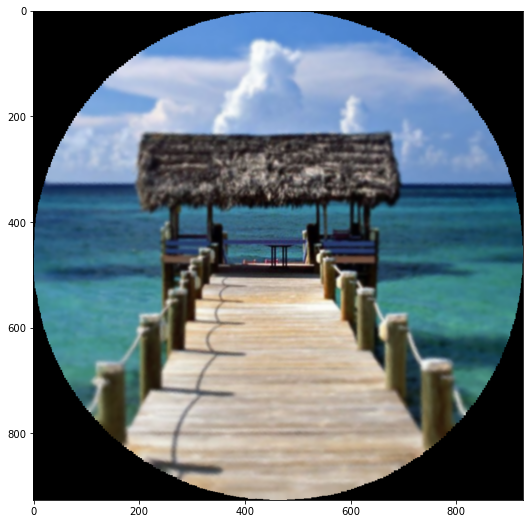

In [7]:
R = Retina('retina_layers.pkl')
R.calibrate(img_gray)
gray_norm = R.normalizationVector
R.calibrate(img)
R.sample(img)
print((R.normalizationVector == gray_norm).all())
R.backProject()
show_backProjected_RGB(R)

In [8]:
%%timeit
R.sample(img)

32 ms ± 860 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [9]:
%%timeit
R.backProject()

55.9 ms ± 447 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
R.calibrate(img_gray)

In [11]:
%%timeit
R.sample(img_gray)

15.3 ms ± 315 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
R.setFixation(0,0)

In [13]:
%%timeit
R.sample(img_gray)

3.86 ms ± 81.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
R.setFixation(1920,1080)

In [15]:
%%timeit
R.sample(img_gray)

3.85 ms ± 64.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
R.setFixation(1920/2,1080/2)

161 ms ± 1.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
import os, psutil
process = psutil.Process(os.getpid())
print(process.memory_info().rss/(2**20))

297.61328125
